# E04_나만의 이미지 분류기 만들어보기

## 1. dataset 내려받기

In [1]:
# pkg 버전으로 인한 경고메세지 출력시 꼭 필요한 경고 메시지만 출력되도록 하기
import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
# data load
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

# data check
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


## 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기
이미지를 모두 같은 크기로 formatting 한 후, `train_batches`, `validation_batches`, `test_batches`를 준비합니다.

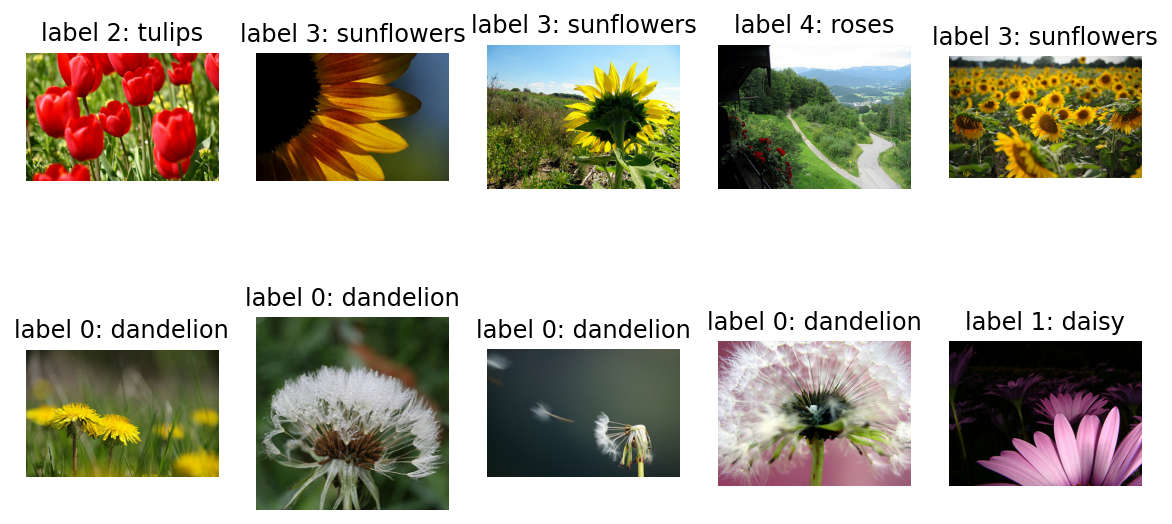

In [4]:
# 데이터를 확인하기 위한 matplotlib라이브러리 가져오기
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

# 0: dandelion  1: daisy   2: tulips   3: sunflowers   4: roses

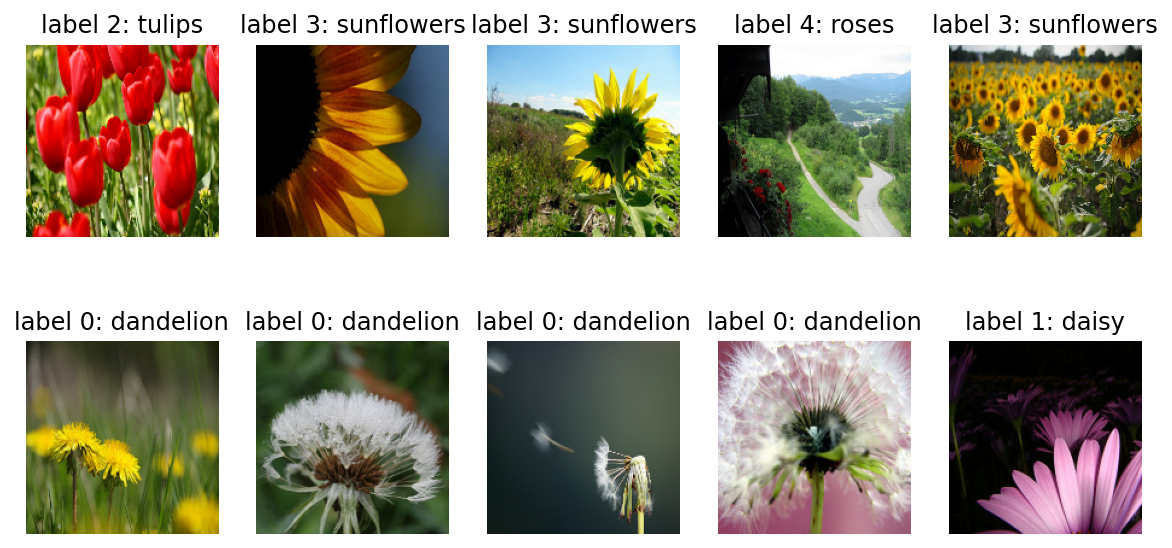

In [5]:
# 160x160, pixel scale fix
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

# 다듬은 데이터셋 사진 출력해보기
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

## 3. 모델 설계하기

In [7]:
# models : 모델 자체 구축위한 함수
# layers : 모델의 구성 요소인 여러 레이어, 즉 "층" 이라는 함수들을 갖고있다
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

#base_learning_rate = 0.0001
#model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
#              loss=tf.keras.losses.sparse_categorical_crossentropy,
#              metrics=['accuracy'])

In [8]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [9]:
# train_batches에서 하나의 batch만 꺼내 데이터 확인해보기
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([10, 160, 160, 3]), TensorShape([10]))

In [10]:
# 잘 학습된 모델 가져오기
# 이미지 인풋을 받아 해당 이미지의 특징을 잘 뽑아낸 특징 벡터를 추출해낼 수 있다
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')


# 모델 구조 확인
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [11]:
# 실제 모델에 이미지 데이터 넣어보기

# 모델에 배치를 넣은 결과 shape
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([10, 5, 5, 512])

In [22]:
# global average pooling
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# global_average_layer에 위에서 VGG16이 출력했던 feature_batch를 입력
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 512)


In [24]:
# 마지막으로 Dense 레이어들을 붙여주면 custumized classifier가 완성됨
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

# vgg16 에 해당하는 base_model은 학습을 시키지 않을 예정이니 
# 학습 여부를 결정하는 trainable변수를 False로 설정한다
base_model.trainable = False

# 최종 모델 만들기
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

# 최종 모델 구조 확인하기
model.summary()

(10, 5)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


In [26]:
# 모델을 compile하면 끝
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# 위 과정과 동일하게 초기 손실, 정확도 값 계산하기
validation_steps=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 5s 239ms/step - loss: 1.7869 - accuracy: 0.2350
initial loss: 1.79
initial accuracy: 0.23


In [ ]:
# 모델 학습 시작
EPOCHS = 5   # 이번에는 이전보다 훨씬 빠르게 수렴되므로 5Epoch이면 충분합니다.

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5
229/294 [======================>.......] - ETA: 18s - loss: 1.2678 - accuracy: 0.5777

## 4. model 학습시키기

#  5. model 성능 평가하기

# 6. model 활용하기